# Recommender System Evaluation

### **Course**: Analysis of Customer Data  
### **Date**: 23 May 2025  

#### **Project Overview**
- **Objective**: The objective of this project is to investigate and compare recommender system algorithms using the MovieLens dataset provided by GroupLens Research. Specifically, the aim is to configure, evaluate, and compare different models against a baseline to assess their predictive performance.

- **Tools and Libraries**:
    - Python
    - NumPy  
    - Surprise (Simple Python Recommendation System Engine)  
    - Pandas  
    - Matplotlib
    - Seaborn

#### **Final Models Used**

- **NormalPredictor**: A baseline model that makes random predictions based on the distribution of ratings in the training set.
- **KNNWithMeans**: A neighbourhood-based method that predicts ratings using the mean ratings of similar users. It applies Z-score normalisation to account for individual rating biases.
- **SVD (Singular Value Decomposition)**: A matrix factorisation technique that captures latent user–item relationships for predicting missing ratings.

#### **Evaluation Metric**

- **Root Mean Squared Error (RMSE)**, computed using 5-fold cross-validation. This metric measures the average magnitude of the error between predicted and actual ratings, with lower values indicating better performance.


#  STEP 1: IMPORT NECESSARY LIBRARIES

In [ ]:
# Importing standard libraries for data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for clean plots
sns.set(style='whitegrid', context='paper', font_scale=1.6, rc={"lines.linewidth": 2})

# Surprise library: for collaborative filtering models and evaluation
from surprise import Dataset, Reader
from surprise import accuracy

# Neighbourhood-based collaborative filtering models
from surprise import NormalPredictor
from surprise import KNNWithMeans, KNNWithZScore, KNNBasic, KNNBaseline

# Matrix factorisation-based models
from surprise import SVD, SVDpp, NMF

# Model selection and evaluation tools
from surprise.model_selection import cross_validate, KFold, GridSearchCV


# STEP 2: LOAD DATA

In [ ]:
# Load the original MovieLens ratings dataset
df_original = pd.read_csv("MovieLens-Ratings.csv")

# Create a working copy to preserve the original dataset
df = df_original.copy()


# STEP 3: STATISTICS

To better understand the dataset, we first started with some basic statistics.
The 'timestamp' column (which indicates when a rating was given) was removed, since the temporal information is not required for the recommender models here.
The focus in our final dataset will be on "userId", "movieId", and "rating".

In [ ]:
# Show the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Remove the 'timestamp' column as it is not needed
df.drop(columns=['timestamp'], inplace=True)

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Check percentage of missing values in the dataset
print("Percent of missing values:", df.isnull().sum().sum() * 100 / len(df))

# Display the range of ratings
print("Rating range: ", df['rating'].min(), "-", df['rating'].max())

# Count the number of unique users and unique movies
print("\nNumber of unique users:", df['userId'].nunique())
print("Number of unique movies:", df['movieId'].nunique())

# Calculate average rating and average number of ratings per user
print("Average rating:", df['rating'].mean())
print("Ratings per user (avg):", df.groupby('userId')['rating'].count().mean())

# Show summary statistics for numerical columns
print(df.describe())

First few rows of the dataset:
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264
Dataset shape: (27753444, 3)
Percent of missing values: 0.0
Rating range:  0.5 - 5.0

Number of unique users: 283228
Number of unique movies: 53889
Average rating: 3.5304452124932677
Ratings per user (avg): 97.98976089934611
             userId       movieId        rating
count  2.775344e+07  2.775344e+07  2.775344e+07
mean   1.419420e+05  1.848800e+04  3.530445e+00
std    8.170740e+04  3.510263e+04  1.066353e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    7.117600e+04  1.097000e+03  3.000000e+00
50%    1.420220e+05  2.716000e+03  3.500000e+00
75%    2.124590e+05  7.150000e+03  4.000000e+00
max    2.832280e+05  1.938860e+05  5.000000e+00


# STEP 4: PREPROCESSING
## Step 4.1 Rating Distribution

After examining some basic statistics, we explored the distribution of ratings in the dataset to identify patterns that might further help us with the preprocessing decisions.

We used bins=10 to ensure the ratings are grouped effectively and distinguishable.

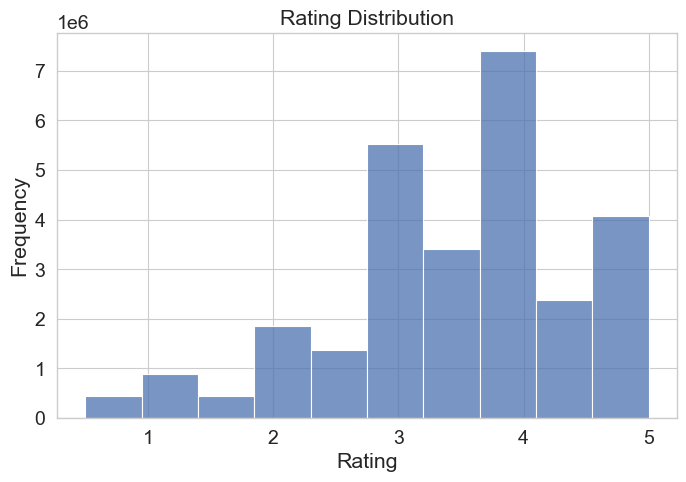

In [ ]:
# Plot rating distirbution
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=10)

# Set title & labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show plot
plt.show()


The histogram shows that rating 4 is the most frequent, followed by rating 5, while lower ratings (1 and 2) are less common. This suggests a positive bias in user ratings, where most individuals tend to rate movies favourably.

Based on this observation, we decided upon applying mean-centering normalisation to correct for user-specific rating tendencies in our neighbourhood-based model. This adjustment allows for fairer comparisons between users who tend to rate generously and those with stricter rating habits when calculating similarities. Without normalisaiton, similarity computations may be skewed, potentially making users appear more similar than they truly are. Mena-centering helps mitigate this issue by adjusting individual ratings relative to each user's average preference, which makes similarity measure more meaningful.

On the other hand, normalisation is unnecessary for our matrix factorisation model. These models inherently learn user biases through latent factor modeling. The model captures patterns in user preferences and adjusts recommendations accordingly, and hence explicit normalisation is not required. The model naturally identifies and compensates for rating biases through its internal learning process.

Thus, we will normalise ratings in the KNN-based model to improve similarity calculations while allowing SVD to handle biases naturally through its internal learning process.

## Step 4.2 User-Behaviours

Next, we wanted to explore user behaviours in our dataset. Specifically, we examined user-specific rating patterns to understand how different users contribute to the ratings and how this might affect our recommendation models.

We started by checking whether certain users rate movies more frequently than others. We also looked for duplicate ratings (users rating the same movie multiple times), identified users who only use extreme values (such as 1 or 5 stars), and evaluated the variance in user ratings to detect those with very consistent or highly variable preferences.

Understanding these behaviours helps us filter the data to improve model performance and reduce bias.


### 4.2.1 Distribution of Ratings per User
The following code groups the data by user and calculates the number of ratings and the mean rating for each user. We then inspect the distribution of these values.

User rating distribution summary:
               count           mean
count  283228.000000  283228.000000
mean       97.989761       3.635359
std       212.760722       0.582801
min         1.000000       0.500000
25%        15.000000       3.323529
50%        30.000000       3.666667
75%        95.000000       4.000000
max     23715.000000       5.000000


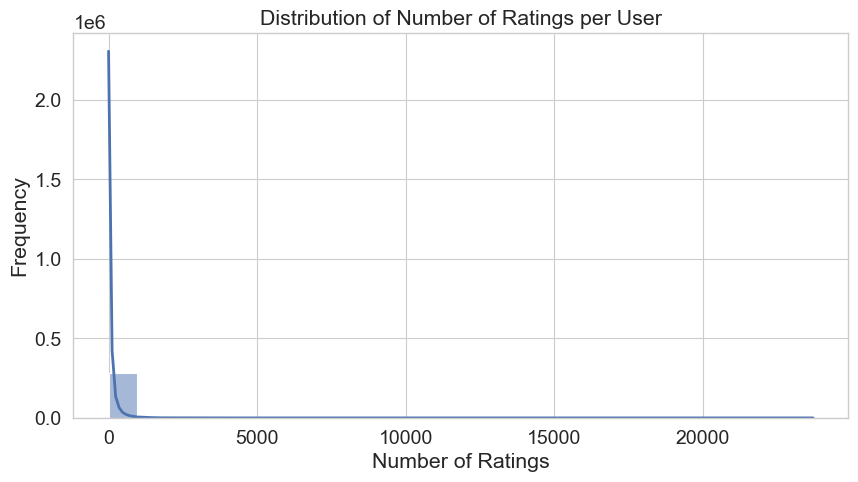

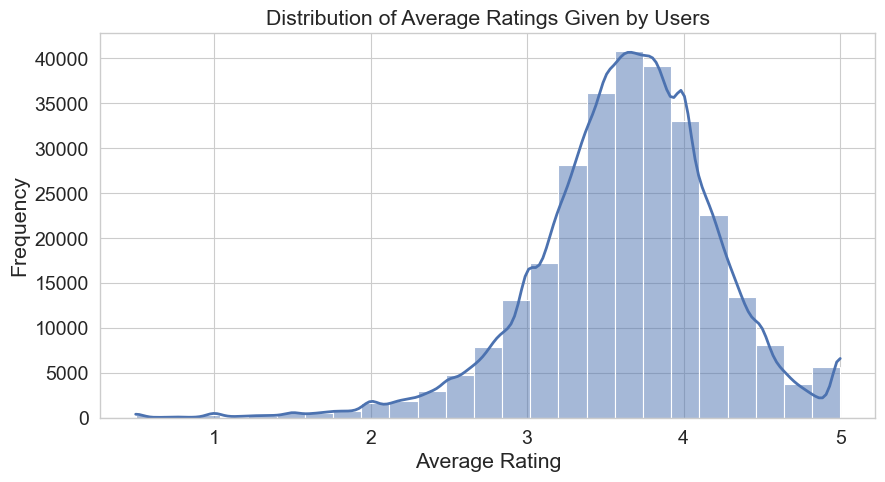

In [ ]:
# Group by userId and calculate:
# 1) 'count': how many ratings each user gave
# 2) 'mean': average rating given by each user
user_ratings = df.groupby('userId')['rating'].agg(['count', 'mean'])

print("User rating distribution summary:")
print(user_ratings.describe())

# Plot histogram for number of ratings per user
plt.figure(figsize=(10, 5))
sns.histplot(user_ratings['count'], bins=25, kde=True)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

print()

# Plot histogram for average rating per user
plt.figure(figsize=(10, 5))
sns.histplot(user_ratings['mean'], bins=25, kde=True)
plt.title("Distribution of Average Ratings Given by Users")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()


Looking at the rating distribution summary, we observed that some users have rated only a handful of movies, while others have rated thousands. This imbalance suggests that a subset of highly active users contribute disproportionately, potentially influencing the dataset dynamics. Users who rate frequently have stronger representation, while those with fewer interactions have less impact.

Additionally, the mean rating per user (3.64) is slightly higher than the overall dataset mean (3.53), suggesting some skewness in rating behaviour. The presence of extremely active users (maximum ratings per user: 23,715) indicates that certain users may dominate similarity calculations, especially in methods relying on user-based comparisons. Their impact on the models is also significant:

- First, in **KNN-based models**, highly active users dominate similarity calculations, which causes neighbour selection to skew towards their preferences. Filtering out these users ensures that similarity calculations reflect a balanced user base rather than being driven by extreme rating behaviours.
- Second, in **matrix factorization models**, latent factors may be biased toward users with excessive interactions, over-representing their preferences and limiting the model’s ability to generalise. Filtering users who contribute an extreme amount of data reduces overfitting, allowing these models to better capture broader patterns.


### 4.2.2 Filtering Users by Rating Count
Given these observations, we apply threshold-based filtering to balance the dataset:
- Remove (inactive) users with very few ratings (less than 30), as they provide limited information and may not contribute meaningfully to the model.
- Remove the top 1% of (highly active) users by rating count to reduce the dominance of excessively active users, which could skew similarity calculations and model training.

We chose 30 as the minimum rating threshold because it corresponds approximately to the median number of ratings per user in the dataset, based on the summary statistics. This means that half of the users rated fewer than 30 movies, and half rated more. Setting the cutoff at the median helps ensure we retain a large and diverse user base while filtering out the least active users who provide limited data.

In [ ]:
min_thres = 30
max_thres = user_ratings['count'].quantile(0.99)  # Top 1% cutoff

# Select users within the acceptable rating range
filtered_users = user_ratings[(user_ratings['count'] >= min_thres) & (user_ratings['count'] <= max_thres)].index

# Filter the original dataframe to keep only these users
df_filtered = df[df['userId'].isin(filtered_users)]

# Summary of filtering impact
print(f"Original number of users: {df['userId'].nunique()}")
print(f"Filtered number of users: {df_filtered['userId'].nunique()}")
print(f"Original number of ratings: {df.shape[0]}")
print(f"Filtered number of ratings: {df_filtered.shape[0]}")
print(f"Percentage of ratings retained: {df_filtered.shape[0] / df.shape[0] * 100:.2f}%")


Original number of users: 283228
Filtered number of users: 140715
Original number of ratings: 27753444
Filtered number of ratings: 21458122
Percentage of ratings retained: 77.32%


After filtering, we retain about 77% of ratings from roughly half the original users, preserving a large and diverse user set. We now have 21458122 ratings.

### 4.2.3 Checking for Duplicate Ratings
Next, we checked whether any users have rated the same movie multiple times, as duplicates could distort model training.

In [ ]:
# Count ratings per user-movie pair to identify duplicates
duplicate_ratings = df_filtered.groupby(['userId', 'movieId']).size().reset_index(name='count')

# Filter user-movie pairs with more than one rating
duplicates = duplicate_ratings[duplicate_ratings['count'] > 1]

# Output total duplicates found and a sample
print(f"Total duplicate ratings found: {duplicates.shape[0]}")
print(duplicates.head())

Total duplicate ratings found: 0
Empty DataFrame
Columns: [userId, movieId, count]
Index: []


No duplicate ratings were found, which means each user-movie pair has only one rating. This ensures data consistency.

### 4.2.4 Identifying and Removing Extreme Raters
Next, we address users who consistently rate movies at the extremes (i.e., giving only 1-star or 5-star ratings). This behaviour limits rating variability, making it difficult for models to differentiate between genuine preferences and rigid rating tendencies, potentially introducing bias in model evaluation.

In **KNN-based models**, extreme users provide little variation, which distorts similarity calculations and affects neighbour selection. Without varied ratings, the system struggles to identify true preference paterns. This leads to misleading user-item similarities.

For **matrix factorisation models**, extreme raters can influence latent factors disproportionately. As a result, bias terms are overemphasised. While these models inherently learn user tendencies, extreme ratings can still affect the learned representations, leading to a reducted recommendation accuracy.

To ensure a more balanced evaluation, we flagged and removed users whose averages were ≤ 1.5 or ≥ 4.5. This filtering helps ensure that model training and evaluation are not influenced by overly rigid rating behaviours, and that metrics like RMSE more accurately reflect real-world prediction performance.

In [ ]:
# Calculate average rating per user on filtered data
user_avg_rating = df_filtered.groupby('userId')['rating'].mean()

# Identify users who only give extreme ratings
extreme_users = user_avg_rating.loc[(user_avg_rating <= 1.5) | (user_avg_rating >= 4.5)].index

print(f"Number of extreme rating users: {len(extreme_users)}")

# Remove extreme raters from the filtered dataset
df_filtered_extreme = df_filtered[~df_filtered['userId'].isin(extreme_users)]

print("Total users after filtering extreme raters:", df_filtered_extreme['userId'].nunique())
print("Total ratings after filtering extreme raters:", df_filtered_extreme.shape[0])


Number of extreme rating users: 3790
Total users after filtering extreme raters: 136925
Total ratings after filtering extreme raters: 21101829


We removed around 3,790 extreme raters, slightly reducing the user base but improving rating diversity and model robustness.

### 4.2.5 Filtering Users by Rating Variance
Finally, we investigated the variance in user ratings to identify individuals with highly inconsistent preferences. Unlike the previous group, who consistently rate very low or very high, these users exhibit unpredictable rating patterns, making it difficult for the model to extract meaningful insights. Filtering them out helps improve evaluation accuracy for both models.

Without filtering, similarity calculations in neighborhood-based models may be distorted. Users with erratic rating behaviors may appear artificially similar, causing the model to select misleading neighbors. By removing these users, KNN-based models can better differentiate profiles based on consistent rating behaviors.

For matrix factorization models, this filtering improves latent feature learning by reducing noise from unpredictable rating trends. While it enhances generalization, overfitting is primarily controlled through regularization techniques, such as L2 penalty in SVD. Removing erratic raters ensures that learned preferences are more representative of actual user behavior, improving recommendation stability.

In [ ]:
# Calculate variance of ratings per user after removing extremes
user_var = df_filtered_extreme.groupby('userId')['rating'].var()

print(user_var.describe())

# Define variance threshold to identify highly variable users
variance_threshold = 1.5

# Users with variance above threshold
high_var_users = user_var[user_var >= variance_threshold].index

print(f"Number of highly variable users: {len(high_var_users)}")

# Remove users with extreme rating variability
df_filtered_var = df_filtered_extreme[~df_filtered_extreme['userId'].isin(high_var_users)]

# Print final summary after all filtering steps
print(f"Total users remaining after filtering: {df_filtered_var['userId'].nunique()}")
print(f"Total ratings remaining: {df_filtered_var.shape[0]}")


count    136925.000000
mean          0.938320
std           0.499050
min           0.000000
25%           0.592498
50%           0.837127
75%           1.171125
max           5.215909
Name: rating, dtype: float64
Number of highly variable users: 16047
Total users remaining after filtering: 120878
Total ratings remaining: 18947255


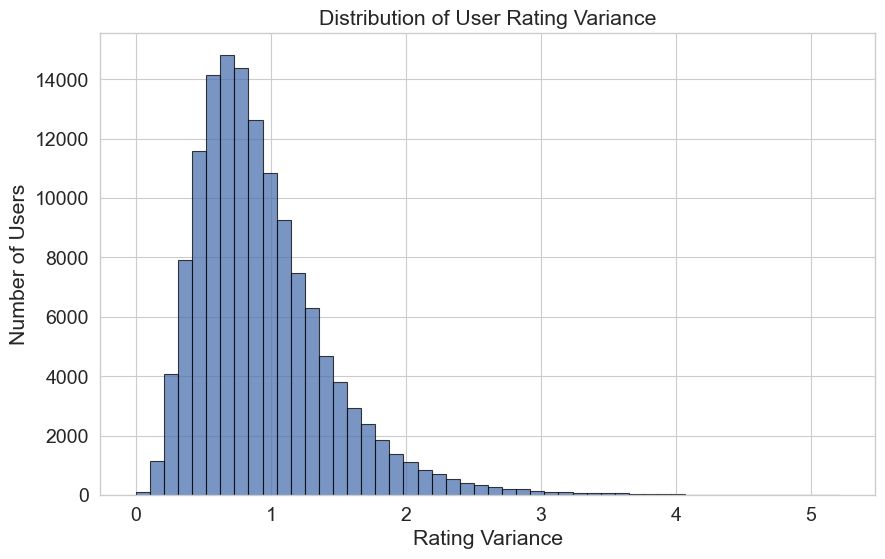

In [ ]:

# Plot histogram of user rating variance
plt.figure(figsize=(10, 6))
plt.hist(user_var, bins=50, edgecolor='black', alpha=0.75)
plt.xlabel('Rating Variance')
plt.ylabel('Number of Users')
plt.title('Distribution of User Rating Variance')
plt.grid(True)
plt.show()

So, it appears that individuals differ in how consistently they rate movies. Some users show high variability in their ratings, while others rate more uniformly. Most users have moderate rating variance—75% of users have a variance ≤ 1.171—suggesting that a quarter of users are significantly more inconsistent in their rating behaviour.

The maximum observed variance is 5.215, which signals extreme rating inconsistency in a small subset of users. We chose a relatively low threshold of 1.5 to flag and remove only those with very inconsistent ratings, while retaining users with reasonable variability. This strikes a balance between removing noise and keeping diversity in the data.
After filtering, the dataset includes about 120,878 users and 18.9 million ratings, achieving a good trade-off between data quality and dataset size.

## Step 4.3 Movie Filtering

Another crucial step in our preprocessing pipeline was to investigate movie-specific rating distributions. The reasoning behind this approach was that certian movies may receive very few ratings, making it difficult to determine reliable trends in user preferences. In a recommender system, movies with sparse ratings can introduce instability in predictions as their scores are based on only a handful opinions.

Additionally, we recognised that some movies exhibit high variance in ratings, since some users rate them extremely high and others very low. These highly polarising movies could complicate model learning, as they do not follow clear preference patterns. However, we do recognise that not all high-variance movies are problematic. Popular movies with difverse opinions (such as controversial blockbusters) can still provide valuable signals for recommendation. So, instead of ouright removing every highly polarised movie, we will filter only those with extreme variance and insufficient ratings.

**KNN-based models** may struggle here because similarity calculations rely on consistent user preferences. Similarly, **matrix factorisation models** might face difficulty learning stable latent factors if a movie has an unpredictable rating distribution.

#### Filtering Strategy
In the next section, we applied three filtering steps to ensure model robustness:
1. Remove movies with very few ratings
2. Manage overrepresented movies (highly rated titles)
3. Identify and remove extreme polarising movies

Summary statistics of rating counts per movie:
count    38125.000000
mean       496.977180
std       2554.779897
min          1.000000
25%          2.000000
50%          6.000000
75%         58.000000
max      69107.000000
Name: rating, dtype: float64


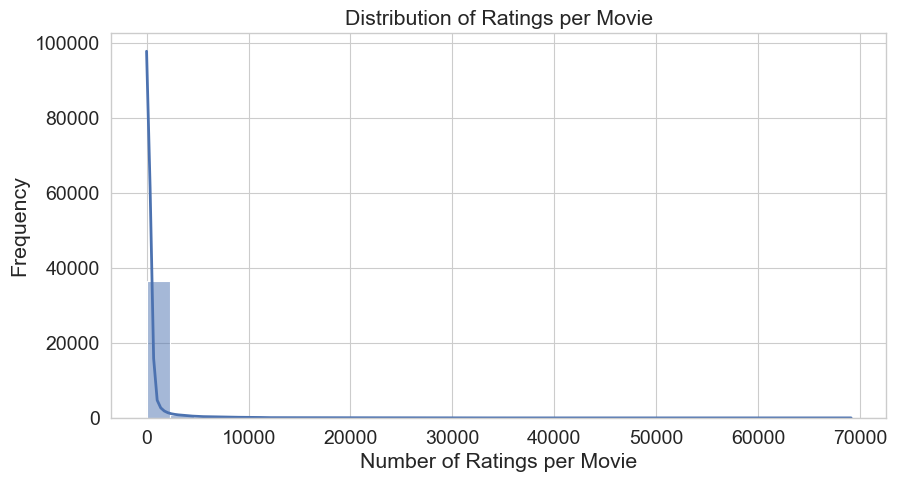

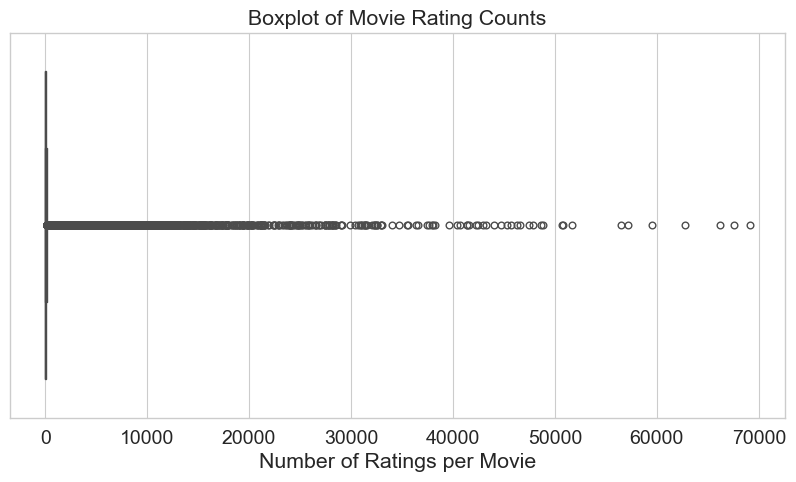

In [ ]:
# Count ratings per movie in the filtered dataset
movie_counts = df_filtered_var.groupby('movieId')['rating'].count()

# Display summary statistics for the number of ratings per movie
print("Summary statistics of rating counts per movie:")
print(movie_counts.describe())
# This helps us understand the distribution, including min, max, median, quartiles

# Plot histogram of ratings per movie
plt.figure(figsize=(10, 5))
sns.histplot(movie_counts, bins=30, kde=True)
plt.title("Distribution of Ratings per Movie")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Frequency")
plt.show()
# The histogram shows how many movies fall into each rating count bin,
# highlighting if many movies have very few or very many ratings
print()

# Plot boxplot to identify outliers in rating counts
plt.figure(figsize=(10, 5))
sns.boxplot(x=movie_counts)
plt.title("Boxplot of Movie Rating Counts")
plt.xlabel("Number of Ratings per Movie")
plt.show()
# Boxplot visualises the spread and highlights extreme outliers (movies with very few or very many ratings)


### 4.3.1 Filtering Movies with Very Few Ratings
Based on the distribution of the movie ratings summary, we observed a large variation in the number of ratings per movie. Some movies were widely reviewed, whereas others have received very few ratings. For example:
- 25% of movies had fewer than 2 ratings
- The median was only 6 ratings
- 75% had fewer than 58 ratings
- Some movies had up to 69,107 ratings

The boxplots also confirmed the presence of significant outliers.

Keeping movies with very few ratings could introduce instability in model performance, as some algorithms struggle to provide meaningful predictions for underrepresented items. By filtering out these movies, we make sure that the models are trained on items with sufficient user interactions, leading to more reliable recommendations.

Taking all of these into consideration, we opted for a minimum threshold of 10 ratings per movie to strike a balance between removing underrepresented movies and retaining sufficient data for modelling. KNN relies on item similarity, so having too many low-rating count movies can cause unstable similarity calculations. On the other hand, matrix factorisation learns latent factors, so low-rating movies might not strongly impact factor learning. This is why we decided on a threshold of 10.


In [ ]:
# Definine minimum threshold
min_movie_ratings = 10

# Select moves that meet the threshold
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index

# Filter dataset to retain movies with enough ratings
df_filtered_movies = df_filtered_var[df_filtered_var['movieId'].isin(filtered_movies)]

# Print statistics
print(f"Total movies after filtering: {df_filtered_movies['movieId'].nunique()}")
print(f"Total ratings after movie filtering: {df_filtered_movies.shape[0]}")

Total movies after filtering: 16383
Total ratings after movie filtering: 18888289


After applying the filtering criteria, the dataset contains 16,383 movies and 18,888,289 ratings remaining for analysis.

### 4.3.2 Handling Movies with Excessive Ratings

Previously, we considered removing movies with excessive ratings, fearing they would overwhelm the recommendation system. However, outright deletion could have negative consequences, as popular movies often serve as strong indicators of user preferences. Instead of filtering them out, we applied log transformation to soften their influence.

Log transformation can be beneficial in several ways:
1. Reduces the dominance of excessively rated movies while preserving their relevance.
2. Compresses large rating counts, ensuring that high-interaction movies don’t skew the model.
3. Maintains generalization, allowing the model to leverage insights from popular movies while preventing them from overshadowing lesser-known items.

In [ ]:
# Apply log transformation to normalize movie rating counts
df_filtered_movies.loc[:, 'log_rating_count'] = np.log1p(df_filtered_movies.groupby('movieId')['rating'].transform('count'))

# Print summary of log-transformed rating counts
print("Log-transformed rating counts applied.")
print(df_filtered_movies[['movieId', 'log_rating_count']].describe())

C:\Users\shari\AppData\Local\Temp\ipykernel_11528\3924665135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_movies.loc[:, 'log_rating_count'] = np.log1p(df_filtered_movies.groupby('movieId')['rating'].transform('count'))


Log-transformed rating counts applied.
            movieId  log_rating_count
count  1.888829e+07      1.888829e+07
mean   1.675210e+04      8.795714e+00
std    3.286029e+04      1.480075e+00
min    1.000000e+00      2.397895e+00
25%    1.035000e+03      8.022569e+00
50%    2.571000e+03      9.054271e+00
75%    6.620000e+03      9.892882e+00
max    1.925790e+05      1.114343e+01


### 4.3.3 Filtering Highly Polarising Movies
Next, we reasoned that highly polarising movies (those with extreme variability in ratings) could distort model evaluation. For example, if a movie receives both very high (5) and very low (1) ratings, it indicates sharply divided user opinions. This makes it difficult for recommender models to generate reliable predictions. However, like we previously said: "not all high-variance movies are problematic. Popular movies with diverse opinions (such as controversial blockbusters) can still provide valuable signals for recommendation. So, instead of outright removing every highly polarised movie, we will filter only those with extreme variance and insufficient ratings."

To proceed, we analyse the distribution of rating variability across movies. By calculating the variance of ratings per movie, we can identify those with extreme rating dispersion. This analysis will help us decide on an appropriate threshold for filtering out such movies.

In [ ]:
# Calculate the variance of ratings for each movie to identify how polarizing each movie is
movie_var = df_filtered_movies.groupby('movieId')['rating'].var()

# Print summary statistics of these variances to understand their distribution
print(movie_var.describe())


count    16383.000000
mean         0.847059
std          0.326286
min          0.061813
25%          0.628494
50%          0.797846
75%          1.006784
max          4.468182
Name: rating, dtype: float64


From the summary statistics, we observe that 75% of movies have a rating variance less than or equal to approximately (<=) 1.01, while the maximum variance is 4.468. This suggests that most movies have relatively low variance in ratings, and only a few are highly polarizing. Based on this, a reasonable cutoff threshold for defining "highly polarizing" movies is set around 1.1.

In [ ]:
# Define a variance threshold to filter out highly polarizing movies
var_thres = 1.1

# Select movie IDs where the rating variance is greater than or equal to the threshold
pol_movies = movie_var[movie_var >= var_thres].index

# Output the number of movies classified as highly polarizing
print(f"Number of highly polarizing movies: {len(pol_movies)}")


Number of highly polarizing movies: 2934


Using a variance threshold of 1.1 to identify highly polarising movies, we found that 2934 movies exhibited extreme rating variability and were therefore excluded from the dataset.

In [ ]:
# Create a filtered DataFrame excluding the highly polarizing movies
df_final = df_filtered_movies[~df_filtered_movies['movieId'].isin(pol_movies)]

# Print how many unique movies remain after filtering out polarizing ones
print(f"Total movies remaining after filtering polarizing ones: {df_final['movieId'].nunique()}")

# Print the total number of ratings remaining after filtering
print(f"Total ratings remaining after filtering: {df_final.shape[0]}")


Total movies remaining after filtering polarizing ones: 13449
Total ratings remaining after filtering: 17790981


After removing the highly polarising movies, the dataset was reduced to 13,449 unique movies with a total of approximately 17.8 million ratings remaining for analysis.

### 4.3.4 Stratified Sampling of the Filtered Dataset
Given the remaining large size of the dataset (approximately 18 million ratings) and the need for efficient model evaluation, we decided to apply Stratified Sampling to select a representative subset of 700,000 ratings for training and testing our recommender system models.

The reasoning behind this approach includes:
1. Balanced representation: The dataset contains ratings from 0.5 to 5.0 and user behaviour varies significantly. Stratified sampling preserve the distribution of ratings, ensuring that each rating level remains proportionally represented in the subset.
2. Reducing evaluation bias: Random sampling could overrepresent frequent raters or popular movies, skewing the model's performance metrics. Stratified sampling helps maintain the diversity in user ratings, avoiding such biases.
3. Computational efficiency: Processing the full dataset (about 18 million ratings) through 5-fold cross-validation is computationally expensive (previously taking over 40 minutes per fold with a simple baseline model). By selecting a smaller but representative subset of around 700,000 ratings, we are still retaining key patterns while drastically reducing computation time without sacrificing data integrity.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the target sample size for ratings to balance computational efficiency and data representativeness
sample_size = 700000

# Initialize StratifiedShuffleSplit to create one split, with test_size proportional to the sample size relative to the full filtered dataset
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=sample_size / len(df_final),
    random_state=42  # Ensures reproducibility of the split
)

# Perform stratified sampling on the filtered dataset based on the 'rating' column
for _, sample_idx in sss.split(df_final, df_final['rating']):
    # Select the sampled subset using the indices generated by StratifiedShuffleSplit
    df_sampled = df_final.iloc[sample_idx].copy()

# Print the shape of the final sampled dataset to verify sample size
print(f"Sampled dataset size: {df_sampled.shape}")


Sampled dataset size: (700000, 4)


This step applies Stratified Sampling to the filtered dataset to create a manageable yet representative subset of 700,000 ratings for model training and evaluation. By stratifying on the 'rating' column, we ensure that the distribution of rating values in the sample mirrors that of the original dataset. This helps maintain diversity and balance across rating levels, which is crucial for unbiased and reliable recommender system evaluation. Setting a fixed random state guarantees that the sampling process can be replicated exactly in future runs.

# STEP 5: NORMALISATION

The histogram showed that the ratings are not evenly distributed, with most ratings concentrated on the higher end of the scale, while lower ratings (1 and 2) are relatively uncommon. This indicates a potential positive bias, where users tend to rate movies favourably. To address this skew in ratings, we applied normalisation technique to ensure fairer comparisons and improved model performance.

KNN-based models rely on calculating similarities between users or items, and by adjusting for individual biases we improve the accuracy of similarity computations. Essentially, this centres the ratings per user, so the model focuses on relative preferences rather than absolute rating values.

For the matrix-factorization model, we did not use normalisation as it inherently learns user biases thorugh latent factor modelling. The model captures patterns in user preferences and adjusts recommendations accordingly, and hence explicit normalisation is not required.

Before performing normalisation for the KNN-model, we created a separate copy of the 'df_sampled'.


In [ ]:
# User-centered normalisation: subtract each user's mean rating from their individual ratings
df_user_centered = df_sampled.copy()
df_user_centered['user_mean'] = df_user_centered.groupby('userId')['rating'].transform('mean')
df_user_centered['rating_centered'] = df_user_centered['rating'] - df_user_centered['user_mean']

# STEP 6: BASELINE MODELS

## 6.1 Baseline for KNN

In [ ]:
# Define the rating scale and prepare the dataset for Surprise
# Surprise expects a DataFrame with columns: userId, itemId (movieId), rating
reader = Reader(rating_scale=(0.5, 5.0))
data_knn = Dataset.load_from_df(df_user_centered[['userId', 'movieId', 'rating']], reader)

# Set up 5-fold cross-validation
# Data is shuffled before splitting and a fixed random seed is set for reproducibility
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize the baseline model: NormalPredictor
# This model ignores all user/item information and predicts ratings randomly
# based on the training set’s rating distribution, serving as a simple benchmark
print("\n---Baseline Model: NormalPredictor ---")
baseline_model = NormalPredictor()

# Evaluate the baseline model with cross-validation, measuring RMSE
baseline_results = cross_validate(
    baseline_model,     # Model to evaluate
    data_knn,           # Dataset in Surprise format
    measures=['RMSE'],  # Evaluation metric
    cv=cv,              # Cross-validation scheme
    verbose=True,       # Show progress and results for each fold
    n_jobs=-1           # Use all CPU cores for faster computation
)

# Calculate and print the average RMSE across all 5 folds
mean_rmse = round(baseline_results['test_rmse'].mean(), 4)
print(f"\nAverage RMSE (Baseline): {mean_rmse}")



---Baseline Model: NormalPredictor ---
Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2992  1.2983  1.2962  1.3004  1.3021  1.2992  0.0020  
Fit time          0.93    0.91    0.93    0.92    0.93    0.92    0.01    
Test time         1.62    1.65    1.65    1.60    1.54    1.61    0.04    

Average RMSE (Baseline): 1.2992


In [ ]:
## 6.1 Baseline Without Normalisation

In [ ]:
# Define the rating scale and prepare the dataset for Surprise
# Using the original sampled dataframe without any normalisation
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df_sampled[['userId', 'movieId', 'rating']], reader)

# Set up cross-validation using the same 5-fold scheme defined earlier (cv)
# This ensures consistent evaluation across all baseline models

# Initialize the baseline model: NormalPredictor
# This model ignores all user/item info and predicts ratings randomly
# based on the training set’s rating distribution, serving as a basic benchmark
print("\n---Baseline Model: NormalPredictor ---")
baseline_model = NormalPredictor()

# Evaluate the baseline model with cross-validation, measuring RMSE
baseline_results = cross_validate(
    baseline_model,     # Model to evaluate
    data,               # Dataset without normalization
    measures=['RMSE'],  # Evaluation metric
    cv=cv,              # Same cross-validation scheme
    verbose=True,       # Show fold-wise progress
    n_jobs=-1           # Use all CPU cores for faster computation
)

# Calculate and print the average RMSE across all 5 folds
mean_rmse = round(baseline_results['test_rmse'].mean(), 4)
print(f"\nAverage RMSE (Baseline): {mean_rmse}")


---Baseline Model: NormalPredictor ---
Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2981  1.3016  1.2998  1.2968  1.3028  1.2998  0.0022  
Fit time          1.23    1.10    1.12    1.08    1.08    1.12    0.06    
Test time         2.85    2.89    2.73    2.60    2.49    2.71    0.15    

Average RMSE (Baseline): 1.2998


The RMSE values for each fold show the error of the baseline NormalPredictor model, which predicts ratings randomly based on the training data distribution. The small standard deviation (Std) indicates consistent performance across folds.

Minor variations in the average RMSE may occur when rerunning the model due to its inherent randomness and stochastic nature. This baseline provides a reference point to evaluate how much better more advanced models perform.
The baseline model was evaluated using 5-fold cross-validation, and the RMSE scores across the folds were quite consistent (i.e., RMSE = 1.299).

The reason for the similar RMSE scores for both Normal Predictor is because this type of predictor itself isn't sensitive to the scale of the input values (i.e., ratings).

# STEP 7: NEIGHBOURHOOD-BASED METHOD

Neighbourhood methods are implemented under collaborative filtering algorithms, specifically in the KNN family of algorithms. There are four main types:

* KNNBasic (Simple)
* KNNWithMeans
* KNNWithZScore
* KNNBaseline

## KNNWithMeans
We chose **KNNWithMeans** as our neighbourhood-based recommender model because it effectively accounts for user rating biases while remaining computationally efficient. Unlike **KNNBasic**, which uses only raw user-item similarities, **KNNWithMeans** adjusts predictions by considering each user’s average rating. This helps avoid skewed recommendations caused by individual rating tendencies.

While **KNNBaseline** applies more advanced bias correction with global baseline estimates, our dataset was already normalised during preprocessing, so there was no need for additional adjustments. Similarly, **KNNWithZScore** uses Z-score normalisation, but since we had already normalised the dataset beforehand, further standardisation with Z-scores is redundant.
Since **KNNWithMeans** achieved RMSE nearly identical to **KNNWithZScore** and outperformed the other KNN variants, while maintaining a simpler bias correction mechanism, we proceeded with this model.

### Hyperparameter Optimisation
We optimised its hyperparameters using grid search to determine the best-performing configuration. The parameter grid explored variations in the following:
- **k** (number of neighbors): To balance between local and global similarity influences. A lower k allows the model to focus on the most relevant items, while a higher k includes broader relations but may introduce noise. According to grid search, the best k was 20, confirming a smaller, more relevant neighborhood improves RMSE.
- **min_k** (minimum neighbors for stable predictions): The values tested were 3, 5. The best performing value of min_k = 5 indicates that requiring at least 5 neighbours provides enough stability without overly restricting recommendations.
- **similarity metric**: We chose 'pearson_baseline' since it performed best in grid search. Pearson correlation effectively captures item relationships without needing extra bias adjustments. We decided to not include cosine similarity or other similarity metrics in our parameter grid because Pearson is typically superior in user-item collaborative filtering.

### Item-Based Filtering & Model Evaluation
We opted for item-based filtering to generate recommendations based on item similarities rather than user similarities. This choice was mainly due to many users rating only a small fraction of movies, making user similarity computations less reliable. Additionally, the dataset contains a significant number of ratings, so in this case item-based filtering is the better choice.

A 5-fold cross-validation was applied to ensure robust model evaluation. This approach reduces overfitting risks and provides a comprehensive assessment of RMSE performance across different data splits.

In [ ]:
print("\n--- Grid Search: KNNWithMeans ---")

# Define the parameter grid for tuning
param_grid = {
    'k': [20, 30, 40],
    'min_k': [3, 5],
    'sim_options': {
        'name': ['pearson_baseline'],
        'user_based': [False]
    }
}

# Perform grid search with 5-fold cross-validation
gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=cv, n_jobs=1)
gs_knn_means.fit(data_knn)

# Print best results
print("Best RMSE (KNNWithMeans):", round(gs_knn_means.best_score['rmse'], 4))
print("Best Parameters (KNNWithMeans):", gs_knn_means.best_params['rmse'])


--- Grid Search: KNNWithMeans ---
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als..

Overall, the best RMSE achieved was **0.8783** with parameters k=30, min_k=5, Pearson similarity, and item-based filtering. This represents a significant improvement over the Normal Predictor baseline RMSE of 1.3.


# STEP 9: MATRIX FACTORISATION-BASED METHOD

Matrix factorisation-based methods are collaborative filtering algorithms that decompose the rating matrix into smaller matrices to approximate missing values. There are three main types:

* SVD (Singular Value Decomposition)
* SVDpp (SVD Plus Plus)
* NMF (Non-Negative Matrix Factorization)

## SVD
We decided to go with **SVD** for our matrix factorisation model, instead of SVD++ or NMF, because it struck the best balance between performance, interpretability, and computational efficiency. SVD breaks down the user-item rating matrix into latent features, revealing hidden relationships between users and movies. Since our dataset consists of explicit ratings, we did not need the added complexity of **SVD++**, which mainly benefits from implicit feedback. While SVD++ can improve recommendation quality by considering unrated interactions, its higher computational cost did not justify its use in our case.

On the other hand, **NMF** was not the best fit for our project because it restricts all latent factors to be non-negative. This limitation makes it less flexible for capturing complex rating behaviours. While NMF is useful in cases where interpretability is a priority, it does not perform as well in collaborative filtering, where negative interactions are just as valuable as positive ones. Based on our results, NMF did not achieve a competitive RMSE, reinforcing our choice to exclude it.

### Hyperparameter Optimisation
To ensure SVD was optimised, we ran a grid search with 5-fold cross-validation, testing different configurations for latent factors, training epochs, learning rate, and regularisation strength.
- n_factors: Controls the number of latent features learned by the model, essentially determining how much detail SVD captures about user-item interactions.
- n_epochs: Represents the number of training iterations and influences how well the model converges.
- lr_all: The learning rate affects how quickly the model updates its parameters during training.
- reg_all: Controls the strength of regularisation, which prevents overfitting by discouraging large parameter values.


In [ ]:
print("\n--- Grid Search: SVD ---")

# Define the parameter grid for tuning
param_grid = {
    'n_factors': [50, 75, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.0075],
    'reg_all': [0.01, 0.02, 0.05]
}

# Perform grid search with 5-fold cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=cv, n_jobs=-1)
gs_svd.fit(data)  # Fit grid search to the dataset

# Print best results
print("Best RMSE (SVD):", round(gs_svd.best_score['rmse'], 4))
print("Best Parameters (SVD):", gs_svd.best_params['rmse'])


--- Grid Search: SVD ---
Best RMSE (SVD): 0.8343
Best Parameters (SVD): {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}


After extensive testing, we identified the following best hyperparameter values, which significantly improved RMSE and stabilized training:

- n_factors[50, 75, 100]: Our best result came with 50 factors, indicating that lower complexity prevented overfitting while still allowing meaningful pattern extraction. Higher values (100 or above) increased RMSE, suggesting that additional latent features introduced noise rather than useful signal.
- n_epochs[20, 30]: 30 epochs produced the best RMSE, confirming that deeper training improved performance without excessive tuning. More epochs did not significantly improve accuracy, making 30 the optimal balance between training depth and generalization.
- lr_all[0.005, 0.0075]: Lower learning rate (0.005) yielded the best RMSE, which indicate that gradual updates helped prevent suboptimal convergence. Also, higher learning rates led to fluctuations, showing that slower adjustments stabilized factor learning.
- reg_all[0.01, 0.02, 0.05]: Best result came with reg_all = 0.05, confirming that stronger regularization helped limit overfitting while preserving meaningful factor relationships. Additionally, lower regularization values did not sufficiently constrain model complexity.

To accelerate hyperparameter tuning, we leveraged n_jobs=-1 in GridSearchCV, enabling parallel processing across all available CPU cores. This significantly reduced computation time while maintaining search effectiveness.

After training across various configurations, our final best-performing SVD model achieved an RMSE of 0.8343, confirming that lower complexity, stable training, and controlled learning rates were essential for optimizing performance.


Ultimately, our best SVD configuration achieved an RMSE of **0.8343**, demonstrating significant accuracy improvements over the baseline Normal Predictor while maintaining computational efficiency.


# STEP 12: FINAL EVALUATION

Our evaluation of the recommender system models using RMSE provides valuable insights into their predictive performance and the trade-offs inherent in the modelling process.
The Normal Predictor, with an RMSE of approximately 1.3, serves as a simple baseline that predicts ratings based on the global average, without accounting for any personalisation or item-specific information. Both **KNNWithMeans (RMSE 0.8783)** and **SVD (RMSE 0.8343)** significantly outperform this baseline, demonstrating that personalised approaches, whether based on neighbourhood similarities or latent factor decomposition, are more effective at capturing user preferences.

While our filtering and normalisation steps improved model accuracy and evaluation robustness, each decision came with potential negative consequences that could have influenced our results:
- During preprocessing, we applied user and item filtering to ensure a more balanced dataset for evaluating recommender models. One such step involved removing users who had rated an extremely large number of movies. While this helped mitigate biases in similarity-based models like KNN, it had a noticeable impact on SVD. SVD benefits from high-frequency users because their extensive rating patterns help define latent factors more effectively. These users contribute significantly to the learning process by capturing broad trends in user preferences. By filtering them out, we unintentionally reduced the amount of structured rating data available. This potentially weakened SVD's ability to generalise across different user behaviours.
- Choice of similarity metric (Pearson baseline) and item-based filtering in KNNWithMeans helped the model focus on meaningful neighbourhoods, but biases and data sparsity can still affect neighbour selection and prediction stability.
- Hyperparameter optimisation through grid search with 5-fold cross-validation ensured that both KNNWithMeans and SVD models were well-tuned for this dataset. Due to this, complexity and generalisation were balanced.
- Normalisation and rating scale considerations potentially influenced the models' interpretation of user preferences, especially for matrix factorisation approaches that rely on consistent rating distributions.

The SVD model’s superior performance indicates that latent factor methods are particularly well-suited for this dataset’s characteristics. Its ability to uncover hidden patterns in user-item interactions enables it to provide more accurate predictions than neighbourhood-based methods.

In conclusion, while personalised recommendation models greatly outperform simple baselines, careful attention to data preprocessing and hyperparameter tuning is critical to unlock their full potential. Future work could explore incorporating implicit feedback (e.g., through SVD++), hybrid approaches combining multiple models, or deeper analysis of sparsity effects to further enhance recommendation quality.

## 12.1: Models' RMSE Comparison

C:\Users\shari\AppData\Local\Temp\ipykernel_11528\3537294524.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha="right")


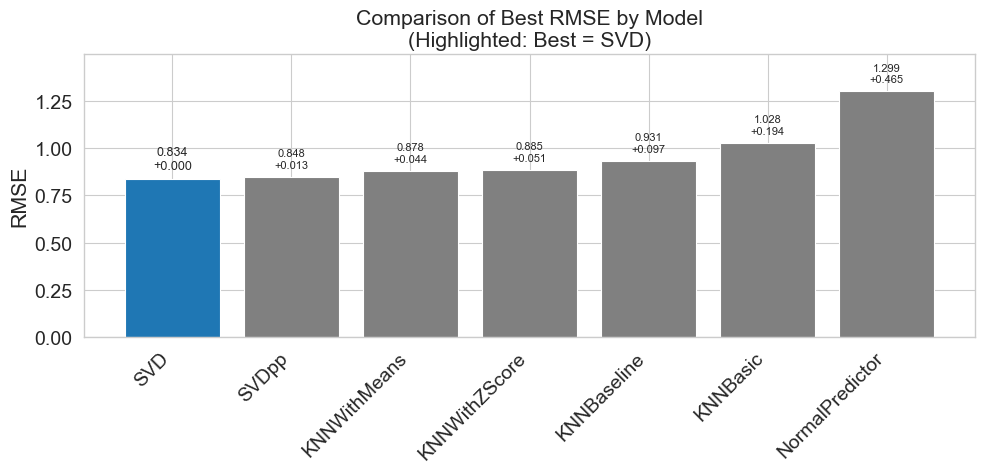

In [ ]:
best_rmse = {
    "NormalPredictor": 1.299,
    "KNNWithMeans": 0.8783,
    "KNNBaseline": 0.9309,
    "KNNBasic": 1.0280,
    "KNNWithZScore": 0.8854,
    "SVD": 0.8343,
    "SVDpp": 0.8478,
}

# 1. Sort
sorted_items = sorted(best_rmse.items(), key=lambda x: x[1])
names = [x[0] for x in sorted_items]
scores = [x[1] for x in sorted_items]
best_score = min(scores)

# 2. Colors
colors = ['tab:blue' if name == 'SVD' else 'grey' for name in names]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(names, scores, color=colors)

# 3. Expand the top of the y-axis so annotations fit
top = max(scores) * 1.15 # 15% headroom
ax.set_ylim(0, top)

# 4. Labels & title
ax.set_ylabel("RMSE")
ax.set_title("Comparison of Best RMSE by Model\n(Highlighted: Best = SVD)")
ax.set_xticklabels(names, rotation=45, ha="right")

# 5. Annotate
for bar, score in zip(bars, scores):
    diff = score - best_score
    label = f"{score:.3f}\n+{diff:.3f}"
    ax.annotate(
        label,
        xy=(bar.get_x() + bar.get_width()/2, score),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=9 if score == best_score else 8
    )

plt.tight_layout()
plt.show()

## STEP 13:  MODEL CODE REPOSITORY

### 13.1 SVD

In [ ]:
print("\n--- Grid Search: SVD ---")

# Define the parameter grid for tuning
param_grid = {
    'n_factors': [100, 150, 200],  # Number of latent factors
    'n_epochs': [20, 30, 50],  # Number of training iterations
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.01, 0.02, 0.05]  # Regularization strength
}

# Perform grid search with 5-fold cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs_svd.fit(data_mf)  # Fit grid search to the dataset

# Print best results
print("Best RMSE (SVD):", round(gs_svd.best_score['rmse'], 4))
print("Best Parameters (SVD):", gs_svd.best_params['rmse'])


--- Grid Search: SVD ---
Best RMSE (SVD): 0.8432
Best Parameters (SVD): {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}


--- Grid Search: SVD ---
Best RMSE (SVD): 0.8435
Best Parameters (SVD): {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}

### 13.2 SVDpp (SVD Plus Plus)

In [ ]:
# GRID SEARCH for SDVpp
print("\n--- Grid Search: SVDpp ---")

# Define the parameter grid
param_grid = {
    'n_factors': [100, 150],  # Number of latent factors
    'n_epochs': [40, 50],  # Number of training epochs
    'lr_all': [ 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.02, 0.05]  # Regularization term for all parameters
}

# Perform grid search
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs_svdpp.fit(data_mf)

# Output best result
print("Best RMSE (SVDpp):", round(gs_svdpp.best_score['rmse'], 4))
print("Best Parameters (SVDpp):", gs_svdpp.best_params['rmse'])



--- Grid Search: SVDpp ---
Best RMSE (SVDpp): 0.8478
Best Parameters (SVDpp): {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}


--- Grid Search: SVDpp ---
Best RMSE (SVDpp): 0.8478
Best Parameters (SVDpp): {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}

### 13.3 KNNBaseline

In [ ]:
print("\n--- Grid Search: KNNBaseline ---")

# Define the parameter grid for tuning
param_grid = {
    'k': [20, 30, 40],  # Number of neighbors
    'min_k': [3, 5],
    'sim_options': {
        'name': ['pearson_baseline'],  # Similarity metrics
        'user_based': [False]
    }
}

# Perform grid search with 5-fold cross-validation
gs_knn_baseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=5, n_jobs=1)
gs_knn_baseline.fit(data_knn)  # Fit grid search to the dataset

# Print best results
print("Best RMSE (KNNBaseline):", round(gs_knn_baseline.best_score['rmse'], 4))
print("Best Parameters (KNNBaseline):", gs_knn_baseline.best_params['rmse'])



--- Grid Search: KNNBaseline ---
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Best RMSE (KNNBaseline): 0.9309
Best Parameters (KNNBaseline): {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}

### 13.4 KNNBasic

In [ ]:
print("\n--- Grid Search: KNNBasic ---")

# Define the parameter grid for tuning
param_grid = {
    'k': [20, 30, 40],  # Number of neighbors
    'sim_options': {
        'name': ['pearson_baseline'],  # Similarity metrics
        'user_based': [False]
    }
}

# Perform grid search with 5-fold cross-validation
gs_knn_basic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_jobs=1)
gs_knn_basic.fit(data_knn)  # Fit grid search to the dataset

# Print best results
print("Best RMSE (KNNBasic):", round(gs_knn_basic.best_score['rmse'], 4))
print("Best Parameters (KNNBasic):", gs_knn_basic.best_params['rmse'])



--- Grid Search: KNNBasic ---
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Co

Best RMSE (KNNBasic): 1.028
Best Parameters (KNNBasic): {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}

### 13.5 KNNWithZScore

In [ ]:
# GRID SEARCH for KNNWithZScore
print("\n--- Grid Search: KNNWithZScore ---")

# Define the parameter grid for tuning; we are testing different values of:
# - 'k': the number of neighbours to consider
# - 'min_k': the minimum number of neighbours required to make a prediction
# - 'sim_options': similarity measures and whether to use user-based or item-based collaborative filtering

param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 5],
    'sim_options': {
        'name': ['pearson_baseline'],
        'user_based': [False]  # Use item-based filtering (NOTE: we can also try True for user-based later, but it crashed everytime)
    }
}

# Perform grid search with 5-fold cross-validation
# Trains the model with every combination of parameters and evaluate them using RMSE
gs_knn = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=5, n_jobs=1)
gs_knn.fit(data)  # Fit the grid search to our Surprise dataset

# Print the best RMSE achieved and the corresponding parameter combination
# Helps with choosing the most effective settings for our KNNWithZScore model
print("Best RMSE (KNNWithZScore):", round(gs_knn.best_score['rmse'], 4))
print("Best Parameters (KNNWithZScore):", gs_knn.best_params['rmse'])



--- Grid Search: KNNWithZScore ---
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

Best RMSE (KNNWithZScore): 0.8843
Best Parameters (KNNWithZScore): {'k': 20, 'min_k': 5, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}

### 13.6 KNNWithMeans

In [ ]:
print("\n--- Grid Search: KNNWithMeans ---")

# Define the parameter grid for tuning
param_grid = {
    'k': [20, 30, 40],# Number of neighbors
    'min_k': [3, 5, 8],
    'sim_options': {
        'name': ['pearson', 'pearson_baseline'],  # Similarity metrics
        'user_based': [False]  # Use item-based filtering (Set to True for user-based)
    }
}

# Perform grid search with 5-fold cross-validation
gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5, n_jobs=1)
gs_knn_means.fit(data_knn)  # Fit grid search to the dataset

# Print best results
print("Best RMSE (KNNWithMeans):", round(gs_knn_means.best_score['rmse'], 4))
print("Best Parameters (KNNWithMeans):", gs_knn_means.best_params['rmse'])


--- Grid Search: KNNWithMeans ---
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity mat

KeyboardInterrupt: 

Best RMSE (KNNWithMeans): 0.8852
Best Parameters (KNNWithMeans): {'k': 20, 'min_k': 5, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}

## 6.2 Baseline for Matrix Factorisation

In [ ]:
# Define the rating scale and prepare the dataset for Surprise
# Here, we use the min-max normalised ratings dataframe 'df_min_max'
# Surprise expects a DataFrame with columns: userId, itemId (movieId), rating
reader = Reader(rating_scale=(0.5, 5.0))
data_mf = Dataset.load_from_df(df_min_max[['userId', 'movieId', 'rating']], reader)

# Reuse the 5-fold cross-validation setup with shuffle and fixed random seed
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize the baseline model: NormalPredictor
# This model ignores user/item features and predicts random ratings based on training distribution
print("\n---Baseline Model: NormalPredictor ---")
baseline_model = NormalPredictor()

# Evaluate the baseline model using cross-validation, measuring RMSE
baseline_results = cross_validate(
    baseline_model,     # Model to evaluate
    data_mf,            # Dataset with normalized ratings
    measures=['RMSE'],  # Evaluation metric
    cv=cv,              # Cross-validation scheme
    verbose=True,       # Display progress and fold results
    n_jobs=-1           # Use all CPU cores for faster computation
)

# Calculate and print the average RMSE across all 5 folds
mean_rmse = round(baseline_results['test_rmse'].mean(), 4)
print(f"\nAverage RMSE (Baseline): {mean_rmse}")



---Baseline Model: NormalPredictor ---
Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2960  1.2963  1.2998  1.2986  1.2985  1.2979  0.0015  
Fit time          0.30    0.33    0.38    0.35    0.31    0.33    0.03    
Test time         0.69    0.72    0.73    0.60    0.65    0.68    0.05    

Average RMSE (Baseline): 1.2979


The baseline model using NormalPredictor achieved an average RMSE of approximately 1.2998 across five cross-validation folds. Since this model predicts ratings randomly based on the overall distribution of the training data, it does not use any information about users or movies. The RMSE value acts as a benchmark, indicating the error level of a naive prediction approach.

Small differences in RMSE between runs are expected due to the randomness in predictions and data splits, but overall, this baseline provides a reference point to evaluate the effectiveness of more advanced models. More advanced models should aim to achieve a lower RMSE than this baseline to prove they are better at predicting ratings.